In [1]:
from qiskit import *
from qiskit.quantum_info import random_statevector
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from scipy.optimize import Bounds
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
import time
pi=np.pi
%matplotlib inline

In [2]:
def norm(vector):
    return sum(abs(vector)**2)

In [3]:
def build_circuit(param_list,qr_length):
    qr=QuantumRegister(qr_length,'q')
    free_circuit=QuantumCircuit(qr)
    num_layers_=int(len(param_list)/(2*qr_length))
    for L in range(num_layers_):

        U_odd_cL=QuantumCircuit(qr)
        for jo in range(qr_length):
            U_odd_cL.rx(param_list[L*2*qr_length+jo],jo)
        
        U_even_cL=QuantumCircuit(qr)
        for je in range(qr_length,2*qr_length):
            U_even_cL.rz(param_list[L*2*qr_length+je],je-qr_length)
        for je in range(qr_length-1):
            U_even_cL.cz(je,range(je+1,qr_length))
                
        U_block_cL=U_odd_cL+U_even_cL
        U_block_cL.barrier()
        free_circuit=free_circuit+U_block_cL
        
        
    return free_circuit

In [4]:
def update_circuit(theta_set,param_list,free_circuit):
    if len(theta_set)==len(free_circuit.parameters):
        qr_length=free_circuit.num_qubits
        num_layers=int(len(theta_set)/(2*qr_length))
        param_dict={}
        for L in range(num_layers):
            for i in range(2*qr_length):
                param_dict[param_list[L*2*qr_length+i]]=theta_set[L*2*qr_length+i]
        my_bound_circuit = free_circuit.bind_parameters(param_dict)    
        return my_bound_circuit

In [5]:
def _cost(theta_set,param_list,free_circuit,target_state):
    
    U_total=update_circuit(theta_set,param_list,free_circuit)
    backend=Aer.get_backend('statevector_simulator')
    job=execute(U_total,backend)
    result = job.result()
    final_state=result.get_statevector()
    
    cost=norm(final_state-target_state.data)
    return cost

In [6]:
# Definitions

qr_length=4
dim=2**qr_length
target_state=random_statevector(dim)
# print(norm(target_state.data))

In [7]:
# Main Code

maxL=10
theta_set = np.ndarray(0)
cost=[]
start=time.time()
for L in range(1,maxL+1):
    start_L=time.time()
    new_set   = np.random.rand(2*qr_length)*2*pi
    theta_set = np.append(theta_set,new_set)
    params=[]
    for cL in range(L):
        for i in range(2*qr_length):
            params.append(Parameter(str(cL+1)+','+str(i+1)))
    circ=build_circuit(params,qr_length)
    mbounds=Bounds(np.zeros(len(theta_set)),np.ones(len(theta_set))*2*pi)
    res=minimize(_cost,theta_set,args=(params,circ,target_state),bounds=mbounds,method='L-BFGS-B')
    print(res.success)
    theta_set=res.x
    cost.append(res.fun)  
    print('cost vector is \n',cost)
    end_L=time.time()
    print('time elapsed for L=',L,'is',end_L-start_L)
    if (L>3 and cost[L-2]<1e-6 and cost[L-1]<1e-6):      
        maxL=L
        print('The required number of layers to converge is L = ',maxL)
        break
end=time.time()
print('Total elapsed time is',end-start)

True
cost vector is 
 [0.719296497855191]
time elapsed for L= 1 is 4.899280548095703
True
cost vector is 
 [0.719296497855191, 0.19190575061102438]
time elapsed for L= 2 is 25.48445749282837
True
cost vector is 
 [0.719296497855191, 0.19190575061102438, 0.060690218945617214]
time elapsed for L= 3 is 67.80087804794312
True
cost vector is 
 [0.719296497855191, 0.19190575061102438, 0.060690218945617214, 0.002367773128671883]
time elapsed for L= 4 is 145.77833795547485
True
cost vector is 
 [0.719296497855191, 0.19190575061102438, 0.060690218945617214, 0.002367773128671883, 1.3000130985763604e-08]
time elapsed for L= 5 is 152.84774231910706
True
cost vector is 
 [0.719296497855191, 0.19190575061102438, 0.060690218945617214, 0.002367773128671883, 1.3000130985763604e-08, 5.298107682390059e-09]
time elapsed for L= 6 is 232.0132703781128
The required number of layers to converge is L =  6
Total elapsed time is 628.825966835022


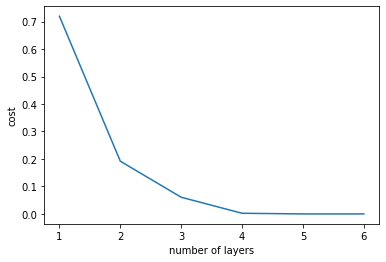

In [8]:
plt.plot(range(1,maxL+1),cost)
plt.xlabel('number of layers')
plt.ylabel('cost')
plt.show()

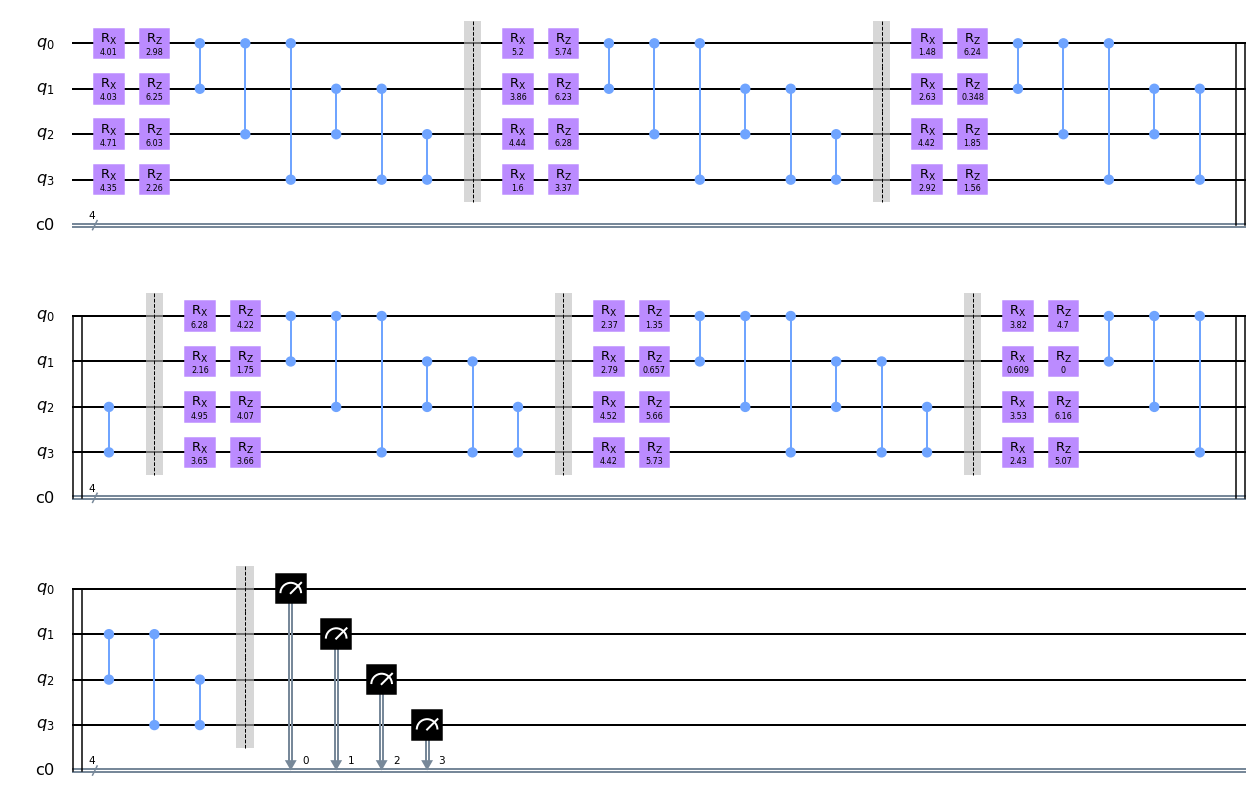

In [9]:
meas = QuantumCircuit(QuantumRegister(qr_length,'q'),ClassicalRegister(qr_length,'c0'))
meas.measure(range(qr_length), range(qr_length))
final_circ = update_circuit(theta_set,params,circ)+meas
final_circ.draw('mpl')

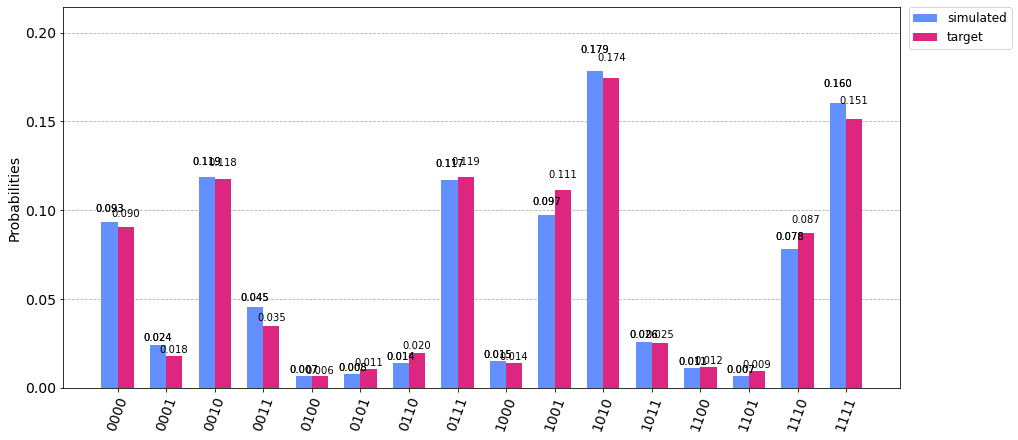

In [11]:
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(final_circ, backend_sim, shots=2048)
result_sim = job_sim.result()
counts = result_sim.get_counts()
# print(counts)
plot_histogram([counts,target_state.sample_counts(2048)],figsize=(15,7),legend=['simulated','target'])